#### 序列数据
- 实际生活中很多数据是有时序结构的
- 电影的评价随时间变化而变化
    - 拿奖后评分上升，但是很久前拿奖的评分提升效果不明显
    - 导演、演员负面报道后评分降低

#### 序列数据 - 更多例子
- 音乐、语言、文本等都是连续的
    - 标题“狗咬人”远没有“人咬狗”那么令人惊讶
- 大地震发生后，很可能会有几次较小的余震
- 预测明天的股价要比填补昨天遗失的股价更难

#### 统计工具
- 在时间 $t$ 观察到 $x_t$ ，那么得到 $T$ 个不独立的随机变量：$(x_1, ... ,x_t) ~ p(x)$
- 使用条件概率展开：$p(a,b) = p(a)p(b|a) = p(b)p(a|b)$

$p(x)=p(x_1) \cdot p(x_2|x_1) \cdot p(x_3|x_1, x_2) \cdot ... p(x_T|x_1,...,x_{T-1})$

也可以反过来推导公式，但是在物理上可能无法实现（无法预测未来会发生什么）

- 对条件概率建模：这样 $f()$ 可以认为是对前 $t-1$ 个数据建立一个模型，来预测第 $t$ 个数据，可称为自回归模型

    $ p(x_t|x_1,...x_{t-1})=p(x_t|f(x1,...,x_{t-1})) $


##### 方案A - 马尔科夫假设

- 假设当前数据只跟 $\tau$ 个过去数据点有关（可以训练一个MLP模型实现）

    $ p(x_t|x_1,...x_{t-1}) = p(x_t|x_{t-\tau},...x_{t-1}) = p(x_t|f(x_{t-\tau},...x_{t-1})) $

##### 方案B - 潜变量模型

- 引入潜变量 $h_t$ 来表示过去信息 $h_t = f(x_1, ...x_{t-1})$
    - 这样 $x_t = p(x_t|h_t) $

![1](images/1.png)

#### 总结
- 时序模型中，当前数据跟之前观察到的数据相关
- 自回归模型使用自身过去数据来预测未来
- 马尔科夫模型假设当前只跟最近少数数据相关，从而简化模型
- 潜变量模型使用潜变量来概括历史信息


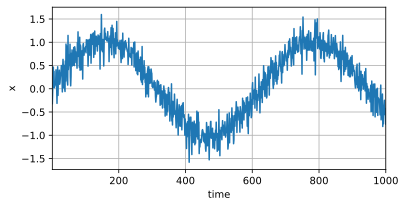

In [1]:
from d2l import torch as d2l
from torch import nn
import torch
%matplotlib inline

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=d2l.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))


In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau): # 对features的每一行分别赋值
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前`n_train`个样本用于训练
train_iter = d2l.load_array(
    (features[:n_train], labels[:n_train]),
    batch_size, 
    is_train=True
)


In [3]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机


def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10), nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net


# 平方损失
loss = nn.MSELoss()


In [4]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


net = get_net()
train(net, train_iter, loss, 5, 0.01)


epoch 1, loss: 0.067952
epoch 2, loss: 0.061278
epoch 3, loss: 0.056933
epoch 4, loss: 0.056930
epoch 5, loss: 0.054388


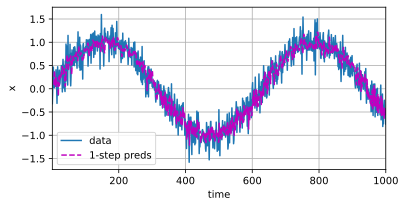

In [5]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))


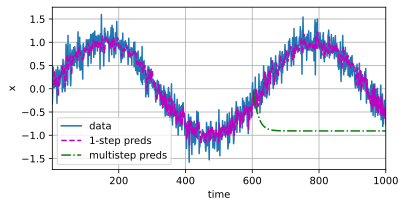

In [8]:
# 进行多步预测
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot(
    [time, time[tau:], time[n_train + tau:]],
    [
        x.detach().numpy(), 
        onestep_preds.detach().numpy(),
        multistep_preds[n_train + tau:].detach().numpy()
    ], 
    'time',
    'x', 
    legend=['data', '1-step preds', 'multistep preds'],
    xlim=[1, 1000], 
    figsize=(6, 3)
)


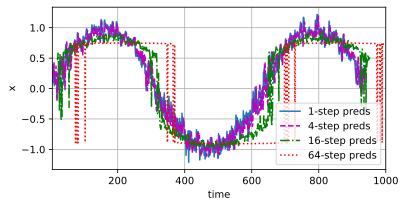

In [9]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot(
    [time[tau + i - 1: T - max_steps + i] for i in steps],
    [features[:, (tau + i - 1)].detach().numpy() for i in steps], 
    'time', 
    'x',
    legend=[f'{i}-step preds' for i in steps
    ], 
    xlim=[5, 1000],
    figsize=(6, 3)
)
